# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) (IN2375) Introduction to Colab and Test Server

In this exercise we provide you with a baseline multi-object tracker on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. The goal is for you to familiarize yourself with the dataset, obtain some preliminary baseline results, and test the submission system, as these will be used through all the exercises. If you already have some ideas on how to improve this baseline, also feel free to play around with them. **Note that this exercise will not be graded**. 

As most modern multi-object trackers, the provided baseline follows the tracking-by-detection paradigm. To this end, an object detector is applied to each frame indepdently and in a subsequent data association step the detections are combined to tracks over multiple frames. The challenge is to connect the correct detections of the same object and produce identity preserving tracks.


In the upcoming exercise assignments, we will extend this tracker with different techniques to improve its performance. The end goal will be for you to combine all the tools we will develop to obtain a top-performing multi-object tracker. The final tracker you will have created by the end of the semester will be benchmarked in a final competition.

## Setup

### Download and extract project data to your Google Drive

1.   Install Google Drive on your desktop.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/u/seidensc/cv3dst/cv3dst_exercise.zip) zip file to your desktop and extract it into the `Colab Notebooks` folder in your Google Drive.
4.   Wait until Google Drive finished the synchronisation. (This might take a while.)


#### Connect the notebook to your Google Drive

In [ ]:
from google.colab import drive

# drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"

The `root_dir` path points to the directory and the content in your Google Drive.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/tracker"

data  models  output  src
data_obj_detect.py  __init__.py		__pycache__  utils.py
data_track.py	    object_detector.py	tracker.py


#### Install and import Python libraries

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 28.8 MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590215 sha256=4b77e28157d19a191abede3689ae175cbb495a1a581630efcd20450f2968838f
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built lap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 148 kB 4.0 MB/s
  Created wheel for motmetrics: filename=motmetrics-1.1.3-py3-none-any.whl size=134197 sha256=800635b4c44dd9c88a3ae3f46e59c137d765d3782d38b61a74026ea214afe63f
  Stored in directory: /tmp/pip-ephem-wheel-cache-y7o4hnxi/wheels/39/60/bf/90b1b02ff42db1bf7f2d2fa3eef2fe8bc46061182cf4ce7b37
Successfully built motmetrics


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

import motmetrics as mm
mm.lap.default_solver = 'lap'

import copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT16Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.


In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-06  MOT16-07	MOT16-08  MOT16-12  MOT16-14


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

In [ ]:
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        if 'seg_img' in frame:
            seg_img = frame['seg_img']
            fig, ax = plt.subplots(1, dpi=dpi)
            fig.set_size_inches(width / dpi, height / dpi)
            ax.imshow(seg_img, cmap='gray')
            plt.axis('off')
            plt.show()
        break

KeyboardInterrupt: ignored

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

Lecture on two-stage detectors will be on 8th of November 2022. The respective Youtube-Recording of 2021 can be found [here](https://youtu.be/6I3m0SsLPo4).
The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model



## Configuration

In [ ]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = 0.3

We want to load the pretrained and modified model. For more information about model saving and loading refer to the Pytoch [webpage](https://pytorch.org/tutorials/beginner/saving_loading_models.html).
In order to load a model, Pytorch needs the declaration of the model to be present.

Here, the definition of `FRCNN_FPN(num_classes, nms_thresh)` can be found in 

`gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/tracker/object_detector.py`.

Therefore, we can load the model including the state_dict with trained parameters.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

Now, let's analyse the loaded detector.

In [ ]:
obj_detect.eval()

The **(transform)** is used to convert from PIL image to numpy array with values in the range of (0,1) and also to apply a mean shift, normalization using a standard deviation and resizing into a predefined allowed spatial range.

The **(backbone)** of the FasterRCNN refers to the feature extraction block. Here, we have a ResNet50, which is pretrained on a large dataset.

The **(fpn)** is a Feature Pyramid Network [arxiv paper](https://arxiv.org/pdf/1612.03144.pdf), that extracts features at multiple scales that are fed into the **(roi_heads)** and **(rpn)**.
This is an extension to the originally proposed Faster-RCNN architecture, where only one feature level was used and instead the anchors had different scales.

The **(fpn)**  outputs the feature maps of size (HxWxfeature_dim) that are fed into the **(rpn)** (Region Proposal Network) and **(box_roi_pool)**. The feature_dim = 256 for all levels whereas the spatial size HxW varies.

The **(rpn)** outputs bounding box limits and a score for each of the HxW feature locations at each feature layer. Those are computed in the regression head **(bbox_pred)** and classification head **(cls_score)**. The output are the 4n anchor locations at the regression head and the n logits at the classification head.

Now starts the FastRCNN architecture:

The **(box_roi_pool)** pooling is reducing the region proposals.
It's input are the outputs of the rpn as well as the feature maps of the backbone.
Since we use the extended version with feature maps at multiple scales from the **(fpn)**, we need to add the MultiScaleROIAlign layer.
Also see this [PyTorch website](https://pytorch.org/vision/0.12/generated/torchvision.ops.MultiScaleRoIAlign.html).
It defines what are the feature maps that we will use to perform the region of interest cropping, as well as the size of the crop after rescaling.
If your backbone returns only one Tensor, featmap_names is expected to
be [0]. More generally, the backbone+fpn should return an OrderedDict[Tensor], and in featmap_names you can choose which feature maps to use.
The method is described in more detail in eq.1 of this [arxiv paper](https://arxiv.org/pdf/1612.03144.pdf).
Here, we determine the output to be a ROI grid of size $7 \times 7$. For each of the bounding boxes we therefore get a tensor of fixed size:
$12544 = 7\times7\times256$

The regression and classification refinement also happens in **(roi_heads)** after the fully-connected layers in **(box_head)** that takes the fixed size of $12544$. 
Here, the **(box_predictor)** refers to the box regression and classification heads that work with the standardized region proposals. This FastRCNN architecture refines the bounding box limits with a regression head **(bbox_pred)** and classifies each bounding box with a classification head **(cls_score)**.


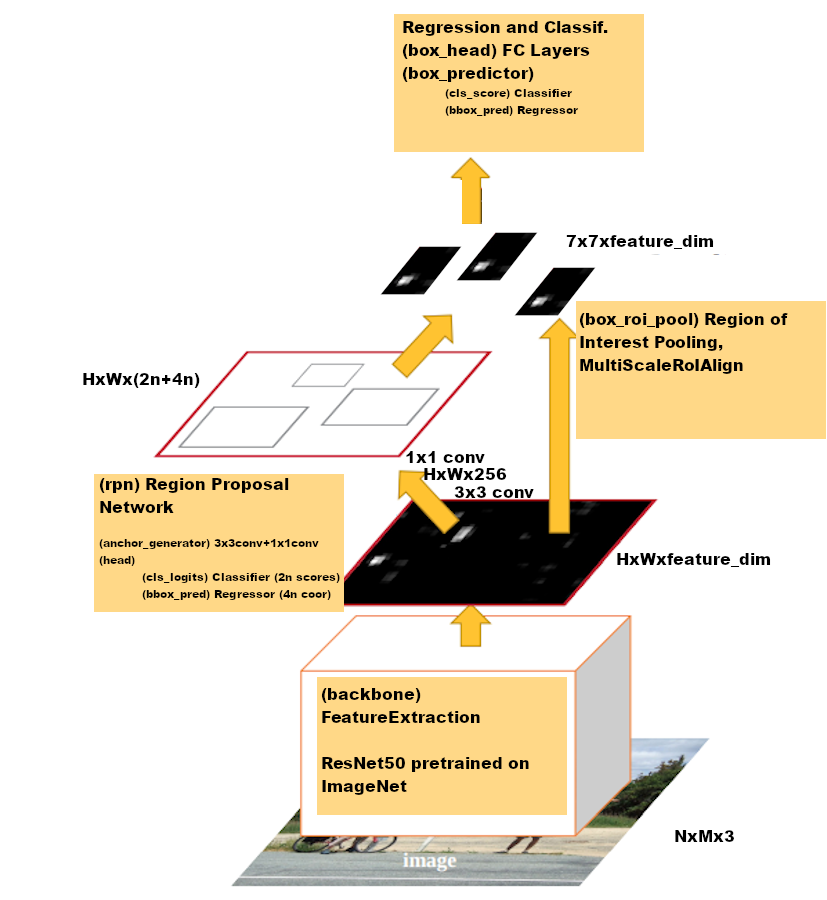



After having understood the overall architecture we can test it's performance on the MOT16 dataset.
If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:  
`AP: 0.878304423893276 Prec: 0.9225370296471914 Rec: 0.9166948510117208 TP: 78602.0 FP: 6600.0
`

The function `evaluate_obj_detect` is defined in `src/tracker/utils.py` and calls the `print_eval` function of the `MOT16ObjDetect` class in `src/tracker/data_obj_detect.py`.
Have a look at the exercise slides in order to understand the meaning of the computed results.

In [ ]:
obj_detect.to(device)
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'),
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

#evaluate_obj_detect(obj_detect, data_loader_test) # <-- takes a while.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union. Note that the output bounding boxes of the detection network are of format (x1, y1, x2, y2). Hence, we need to reformulate them to be used for the iou_matrix computation with py-motmetrics to format (x1, y1, w, h).

Try to understand the baseline tracker and think of ideas on how to improve it with the knowledge from the lecture or even beyond.

## Configuration

In [ ]:
seed = 12345
seq_name = 'MOT16-01'
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

## Setup

In [ ]:
def ltrb_to_ltwh(ltrb_boxes):
    ltwh_boxes = copy.deepcopy(ltrb_boxes)
    ltwh_boxes[:, 2] = ltrb_boxes[:, 2] - ltrb_boxes[:, 0]
    ltwh_boxes[:, 3] = ltrb_boxes[:, 3] - ltrb_boxes[:, 1]

    return ltwh_boxes

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)

# tracker
class TrackerIoUAssignment(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0) # old boxes
            # track_boxes[trackid,dim] 
            # with:
            # trackid = 1,...,num_tracks (t.id is an increasing index)
            # dim = 1...4 (for ltwh)
            iou_track_boxes = ltrb_to_ltwh(track_boxes) # old boxes
            iou_boxes = ltrb_to_ltwh(boxes) # new boxes

            # compute the distance matrix distance[trackid,trackid]
            # with:
            # trackid = 1,...,num_tracks (t.id is an increasing index)
            distance = mm.distances.iou_matrix(
                iou_track_boxes, iou_boxes.numpy(), max_iou=0.5)

            #### update existing tracks

            # fill remove_track_ids with tracks that have no IoU>max_iou with any box in next frame
            # update t.box with limits of matched box in next frame
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                # here dist = distance[trackid], which is a 1-dimarray of size num_tracks
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    # argmin matching
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id] # only keep the current box position, replace old one
            # remove unmatched tracks
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            #### add new tracks

            # fill new_boxes and new_scores with new detections that have no IoU>max_iou with any box in last frame
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)
        

tracker = TrackerIoUAssignment(obj_detect)

## Run tracker

In [ ]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        # get obj_detection result = [box, score] 
        # call the function data_association which we defined above
        tracker.step(frame)

    # after all frames have been processed, this returns the computed tracks for every frame that have been stored in results for evaluation purposes
    results = tracker.get_results()
    # store for every sequence
    results_seq[str(seq)] = results

    # if GT available, compute the mot errors by evaluate_mot_accums
    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        # store for every sequence
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-01


  0%|          | 0/450 [00:00<?, ?it/s]

No GT evaluation data available.
Tracks found: 343
Runtime for MOT16-01: 228.8 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-01.txt
Runtime for all sequences: 228.8 s.


The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT16-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT16-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT16-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT16-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT16-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT16-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT16-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

For your final submission you should focus on improving both `MOTA` and `IDF1`.

A detailed description of the evaluation metrics can be found at the bottom of this [website](https://motchallenge.net/results/MOT16/), this [paper](https://arxiv.org/pdf/1504.01942.pdf) or the exercise slides.

## Visualize tracking results

In [ ]:
plot_sequence(results_seq['MOT16-01'],
              [s for s in sequences if str(s) == 'MOT16-01'][0],
              first_n_frames=10)

Output hidden; open in https://colab.research.google.com to view.

# Notes and next steps

*   Experiment and debug on a single train sequence. If something works on a single sequence evaluate all train sequences to check the generaliztion of your improvement.
*   Remember to split the training set into multiple sets with different sequences if you train something and want to avoid overfitting.
*   Sometimes the execution of a cell gets stuck. If this happends just abort the execution and restart the cell.
*   If the notebook warns you that currently no GPU hardware acceleration is available, try again later and focus on some debugging or experiments than can be done only with the CPU.
* Try to improve your results on your local train/validation splits before submitting to our test servers. The submission will be limited to avoid overfitting to the test sequences.


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences for which you have to change seq_name to MOT16-test. Then you have to upload the zipped prediction files to our server. More information on this will follow.


In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/"

MOT16-01.txt  MOT16-02.txt
